In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score


In [2]:
data_path = r"C:/Users/r/Machine_Learning/HRV Early cardiac risk detection"
df = pd.read_csv(os.path.join(data_path, "heart_rate.csv"))
df.head()


,T1,T2,T3,T4
0,84.2697,91.4634,60.4839,59.2885
1,84.2697,91.4634,60.4839,59.2885
2,84.0619,91.1834,60.4606,59.2885
3,85.6542,91.8788,60.3391,58.8973
4,87.2093,91.1772,60.0762,58.4359


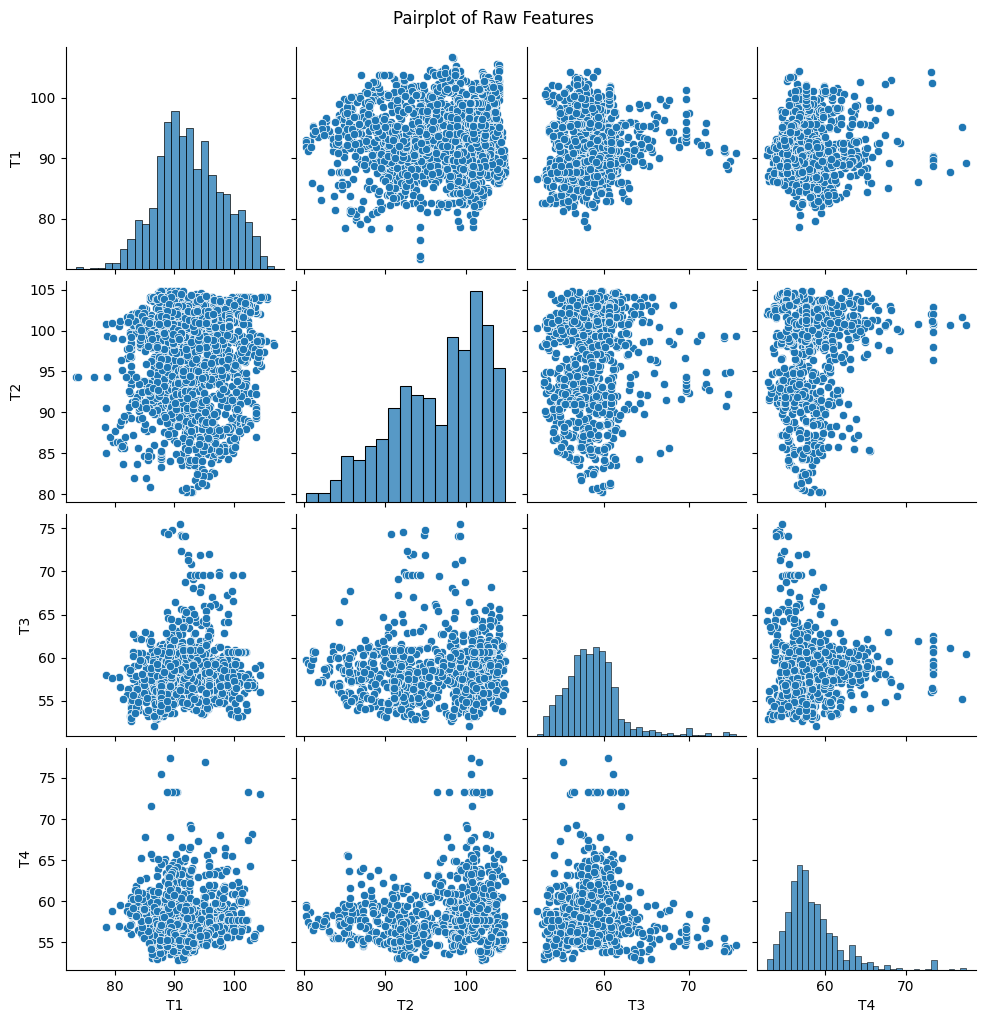

In [3]:
# Step 2: Basic EDA
# -----------------------------
sns.pairplot(df)
plt.suptitle("Pairplot of Raw Features", y=1.02)
plt.show()


In [4]:
# Step 3: Risk Label Assignment Example
# -----------------------------
df['risk_label'] = ((df['T1'] > 85) | (df['T4'] < 58)).astype(int)
print(df['risk_label'].value_counts())

# -----------------------------

risk_label
1    1674
0     126
Name: count, dtype: int64


In [5]:
# Step 4: CAN Screening Example Logic
# -----------------------------
def can_risk_flags(row):
    flags = 0
    if row['T1'] < 70:
        flags += 1
    if row['T2'] < 70:
        flags += 1
    if row['T3'] < 70:
        flags += 1
    if row['T4'] < 58:
        flags += 1
    return flags

df['can_flags'] = df.apply(can_risk_flags, axis=1)
df['possible_can_risk'] = (df['can_flags'] >= 2).astype(int)
print(df[['can_flags', 'possible_can_risk']].describe())

         can_flags  possible_can_risk
count  1800.000000        1800.000000
mean      0.790000           0.262222
std       0.831101           0.439965
min       0.000000           0.000000
25%       0.000000           0.000000
50%       1.000000           0.000000
75%       2.000000           1.000000
max       2.000000           1.000000


In [6]:
# Step 5: Cross-Validation for Best Model
# -----------------------------
X = df[['T1', 'T2', 'T3', 'T4']]
y = df['risk_label']

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss')
}

print("\nCross-Validation Results:")
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"{name}: Mean Accuracy = {scores.mean():.4f} | Std = {scores.std():.4f}")



Cross-Validation Results:
Random Forest: Mean Accuracy = 0.9933 | Std = 0.0120
XGBoost: Mean Accuracy = 0.9894 | Std = 0.0144


In [7]:
# Step 6: Final Model Training (XGBoost Example)
# -----------------------------
model = XGBClassifier(eval_metric='logloss')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

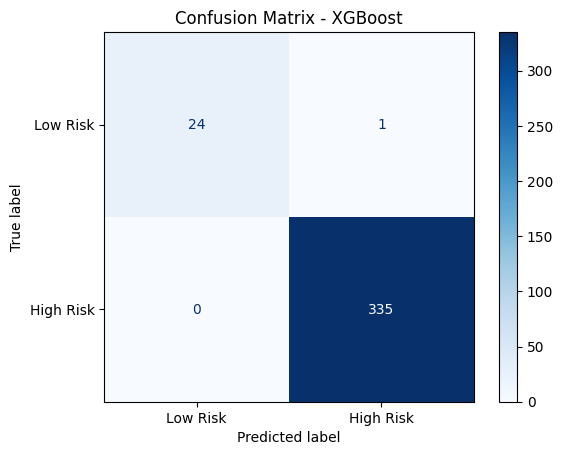

In [8]:
# Step 7: Evaluation
# -----------------------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Risk", "High Risk"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost")
plt.show()

In [9]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       1.00      1.00      1.00       335

    accuracy                           1.00       360
   macro avg       1.00      0.98      0.99       360
weighted avg       1.00      1.00      1.00       360



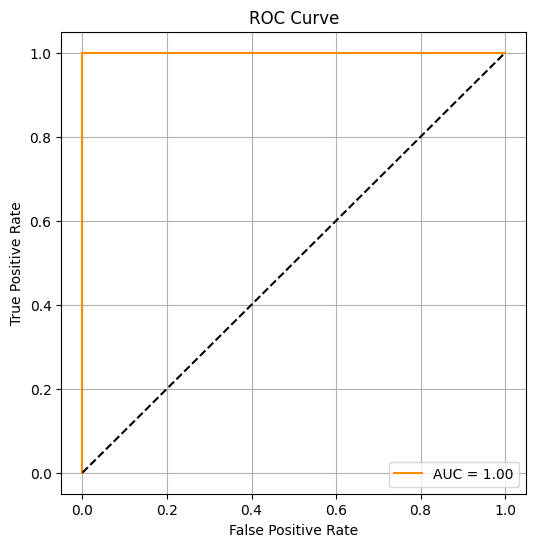

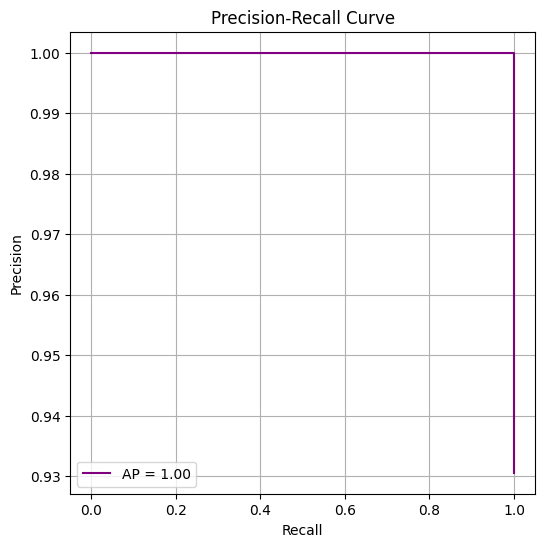

In [10]:
# ROC Curve
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, label=f"AP = {avg_precision:.2f}", color='purple')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()

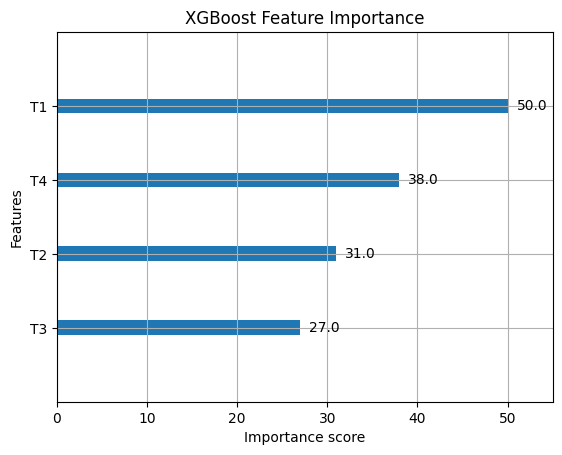

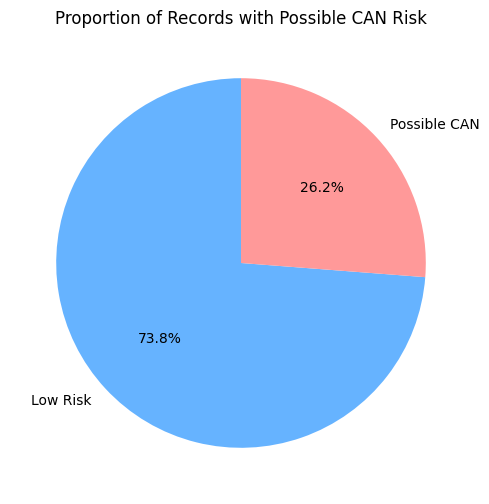

In [11]:
# Step 8: Feature Importance
# -----------------------------
plot_importance(model)
plt.title("XGBoost Feature Importance")
plt.show()

# -----------------------------
# Step 9: Optional CAN Risk Distribution Plot
# -----------------------------
pie_counts = df['possible_can_risk'].value_counts().reindex([0,1], fill_value=0)

plt.figure(figsize=(6,6))
plt.pie(pie_counts, labels=["Low Risk", "Possible CAN"], autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title("Proportion of Records with Possible CAN Risk")
plt.show()
